##Scrapping Google Apps Review - MyBluebird
Week 2 NLP Pipeline PBA/ Genap 2025/ Irmasari Hafidz irma@its.ac.id

edited by Mohammad Geresidi Rachmadi - 5026221163

In [17]:
!pip install google_play_scraper
!pip install textblob
!pip install seaborn
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.2 MB/s eta 0:00:00


## Data Collection ##

Initial Setup

In [19]:
from google_play_scraper import app
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
import nltk
from collections import Counter
from nltk.tokenize import word_tokenize
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import WordNetLemmatizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


%matplotlib inline
%config InlineBackend.figure_format='retina'

# Import seaborn styles explicitly
import seaborn as sns
# Apply the seaborn style before creating plots
sns.set_style("whitegrid")  # This line sets the Seaborn style

plt.rcParams["figure.figsize"] = (15,10)

Get data from = "https://play.google.com/store/apps/details?id=com.seatech.bluebird&hl=en", Online Taxi Mobile Apps.

In [20]:
#https://play.google.com/store/apps/details?id=com.seatech.bluebird&hl=en


from google_play_scraper import app, Sort, reviews_all

mbb_reviews = reviews_all(
    'com.seatech.bluebird',
    sleep_milliseconds=0, # defaults to 0
    lang='en', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

Save the data into a dataframe

In [21]:
df_mbbrev = pd.DataFrame(np.array(mbb_reviews),columns=['content'])
df_mbbrev = df_mbbrev.join(pd.DataFrame(df_mbbrev.pop('content').tolist()))

Mask username

In [22]:
def mask_username(username):
    if pd.isna(username):
        return username
    username = str(username)
    if len(username) <= 4:
        return "*" * len(username)
    return username[:2] + "*" * (len(username)-4) + username[-2:]

df_mbbrev['userName'] = df_mbbrev['userName'].apply(mask_username)

Save raw data (with username masking) to csv

In [64]:
df_mbbrev.to_csv("mybluebird_raw.csv", index=False)

In [24]:
df_mbbrev

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,47de2ac3-fccf-4513-8bd1-47c20c1a021f,A *********er,https://play-lh.googleusercontent.com/EGemoI2N...,aplikasi sampah gabisa order sama sekali yang ...,1,0,None,2025-09-06 12:55:11,"Dear Bapak/Ibu Fats Creamery, mohon maaf atas ...",2025-09-06 12:59:33,None
1,84d05191-c99e-4677-a48c-e7929a7f4053,A *********er,https://play-lh.googleusercontent.com/EGemoI2N...,fantastic app service is AAA+++,5,0,6.18.2,2025-09-04 09:05:11,"Dear Mr/Ms Anna Kingsford , thank you for the ...",2025-09-04 09:10:31,6.18.2
2,ca8658f5-aa92-4dee-aec0-1abab5cef7e2,A *********er,https://play-lh.googleusercontent.com/EGemoI2N...,ini aplikasi bagus hanya saja banyak supir2 ba...,1,0,6.18.2,2025-09-04 02:08:46,Selamat pagi Bapak/Ibu mohon maaf atas ketidak...,2025-09-04 02:22:30,6.18.2
3,b9613d3b-1739-4d3f-a922-b2471d0dcc41,A *********er,https://play-lh.googleusercontent.com/EGemoI2N...,In which country taxi available,1,0,6.18.2,2025-09-03 17:10:23,"Dear Mr/Ms Motorola New app, apologize for the...",2025-09-03 17:14:49,6.18.2
4,b2dea589-687d-4c6a-b22e-933405b57f00,A *********er,https://play-lh.googleusercontent.com/EGemoI2N...,Efficient service. Clean vehicles. Language be...,4,0,6.18.2,2025-09-03 04:55:57,"Hi Kumar Sapre , thank you for the rating :) D...",2025-09-03 05:28:46,6.18.2
...,...,...,...,...,...,...,...,...,...,...,...
9656,2e7a5e6a-e376-47e4-b001-64fe97421afc,A *********er,https://play-lh.googleusercontent.com/EGemoI2N...,Great app. Sangat membantu.,4,1,1.2.127,2011-12-07 23:57:37,None,NaT,1.2.127
9657,01814132-db78-47a4-914d-efd23e986e40,A *********er,https://play-lh.googleusercontent.com/EGemoI2N...,"Akhirnya setelah di blackberry, dibuat juga ap...",5,1,1.2.126,2011-12-07 02:58:14,None,NaT,1.2.126
9658,cdc031c1-088a-4619-928c-c7c1cd2d1e75,A *********er,https://play-lh.googleusercontent.com/EGemoI2N...,Pagi jam 4 saya pesan taksi berjalan dengan ba...,4,2,1.2.126,2011-12-02 22:11:34,None,NaT,1.2.126
9659,4d2cc639-e04a-40f5-86c8-d654a58f0886,A *********er,https://play-lh.googleusercontent.com/EGemoI2N...,Pertama kali make app ini gw seneng banget kar...,2,2,1.2.126,2011-11-30 02:24:32,None,NaT,1.2.126


In [25]:
df_mbbrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9661 entries, 0 to 9660
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              9661 non-null   object        
 1   userName              9661 non-null   object        
 2   userImage             9661 non-null   object        
 3   content               9655 non-null   object        
 4   score                 9661 non-null   int64         
 5   thumbsUpCount         9661 non-null   int64         
 6   reviewCreatedVersion  8698 non-null   object        
 7   at                    9661 non-null   datetime64[ns]
 8   replyContent          8561 non-null   object        
 9   repliedAt             8561 non-null   datetime64[ns]
 10  appVersion            8698 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 830.4+ KB


# Data preprocessing #

# a. without tokenization and stemmering

Lowercasing

In [26]:
df_mbbrev['content'] = df_mbbrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print ("Before lowercasing:")
print(df_mbbrev['content'][11])
print(df_mbbrev['content'][1])
print(df_mbbrev['content'][20])
print ("\nAfter lowercasing:")
df_mbbrev['content']= df_mbbrev['content'].apply(lambda x: x.lower())
print(df_mbbrev['content'][11])
print(df_mbbrev['content'][1])
print(df_mbbrev['content'][20])

Before lowercasing:
When writing a message, it always errors
fantastic app service is AAA+++
saat mengisi email, katanya wrong format. saya hubungi cs nya. diminta via wa saya hub wa, dijawab pakai robot aplikasi ga bermanfaat

After lowercasing:
when writing a message, it always errors
fantastic app service is aaa+++
saat mengisi email, katanya wrong format. saya hubungi cs nya. diminta via wa saya hub wa, dijawab pakai robot aplikasi ga bermanfaat


Tokenization

In [27]:
df_mbbrev['tokens'] = df_mbbrev['content'].str.lower().str.split()
all_tokens = [word for tokens in df_mbbrev['tokens'] for word in tokens]
counter = Counter(all_tokens)
top_50 = counter.most_common(50)
print(top_50)

[('the', 3159), ('to', 2446), ('and', 1676), ('tidak', 1671), ('i', 1624), ('di', 1549), ('dan', 1509), ('driver', 1474), ('bisa', 1424), ('saya', 1402), ('app', 1305), ('aplikasi', 1190), ('ada', 1043), ('taxi', 1033), ('is', 1005), ('yg', 962), ('ga', 902), ('it', 892), ('a', 874), ('order', 842), ('for', 835), ('my', 817), ('sudah', 796), ('yang', 755), ('in', 718), ('this', 703), ('good', 702), ('not', 695), ('untuk', 686), ('ini', 636), ('ke', 634), ('bluebird', 628), ('but', 582), ('blue', 574), ('apps', 571), ('sangat', 554), ('very', 553), ('gak', 521), ('nya', 509), ('you', 508), ('lebih', 505), ('tapi', 503), ('mau', 495), ('on', 487), ('of', 468), ('easy', 468), ('no', 447), ('bird', 446), ('use', 440), ('dari', 436)]


Stopword removal

In [28]:
# Create stopword remover
factory = StopWordRemoverFactory()
id_stopwords = set(factory.get_stop_words())

# Apply stopword removal to the 'content' column
df_mbbrev['tokens_stopword_rm'] = df_mbbrev['tokens'].apply(lambda tokens: [w for w in tokens if w not in id_stopwords])

In [29]:
nltk.download('stopwords')

english_stopwords = set(stopwords.words('english'))

df_mbbrev['tokens_stopword_rm'] = df_mbbrev['tokens_stopword_rm'].apply(
    lambda tokens: [w for w in tokens if w not in english_stopwords]
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [30]:
print(df_mbbrev['tokens_stopword_rm'])

0       [aplikasi, sampah, gabisa, order, sama, sekali...
1                       [fantastic, app, service, aaa+++]
2       [aplikasi, bagus, banyak, supir2, baru, ga, ta...
3                              [country, taxi, available]
4       [efficient, service., clean, vehicles., langua...
                              ...                        
9656                     [great, app., sangat, membantu.]
9657    [akhirnya, blackberry,, dibuat, aplikasi, buat...
9658    [pagi, jam, 4, pesan, taksi, berjalan, baik,, ...
9659    [pertama, kali, make, app, gw, seneng, banget,...
9660           [cant, order, taxi, phone,, apps, answer!]
Name: tokens_stopword_rm, Length: 9661, dtype: object


In [31]:
# Download WordNet (only once)
nltk.download('wordnet')
nltk.download('omw-1.4')

# English Lemmatizer
lemmatizer = WordNetLemmatizer()

# Indonesian Stemmer
factory = StemmerFactory()
indo_stemmer = factory.create_stemmer()

# Function to stem/lemmatize per token
def stem_or_lemmatize(tokens):
    processed = []
    for w in tokens:
        # Simple heuristic: check if word is ASCII (likely English)
        if w.isascii():
            processed.append(lemmatizer.lemmatize(w))
        else:
            processed.append(indo_stemmer.stem(w))
    return processed

# Apply to your DataFrame
df_mbbrev['tokens_stemmed'] = df_mbbrev['tokens'].apply(stem_or_lemmatize)

print(df_mbbrev[['tokens', 'tokens_stemmed']].head())


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


                                              tokens  \
0  [aplikasi, sampah, gabisa, order, sama, sekali...   
1              [fantastic, app, service, is, aaa+++]   
2  [ini, aplikasi, bagus, hanya, saja, banyak, su...   
3              [in, which, country, taxi, available]   
4  [efficient, service., clean, vehicles., langua...   

                                      tokens_stemmed  
0  [aplikasi, sampah, gabisa, order, sama, sekali...  
1              [fantastic, app, service, is, aaa+++]  
2  [ini, aplikasi, bagus, hanya, saja, banyak, su...  
3              [in, which, country, taxi, available]  
4  [efficient, service., clean, vehicles., langua...  


In [32]:
# Recombine stemmed tokens back into strings
df_mbbrev['clean_text'] = df_mbbrev['tokens_stemmed'].apply(lambda x: ' '.join(x))

In [33]:
from textblob import TextBlob

# On raw text (as originally written)
df_mbbrev['raw_polarity'] = df_mbbrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_mbbrev['raw_subjectivity'] = df_mbbrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

# On cleaned/stemmed text
df_mbbrev['clean_polarity'] = df_mbbrev['clean_text'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_mbbrev['clean_subjectivity'] = df_mbbrev['clean_text'].astype(str).apply(lambda x: TextBlob(x).subjectivity)


Create a new dataframe for relevant columns

In [34]:
df_analysis = df_mbbrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

In [35]:
#Check number of reviews scores
df_mbbrev['score'].value_counts()

,count
score,
5,3908
1,3165
2,944
4,849
3,795


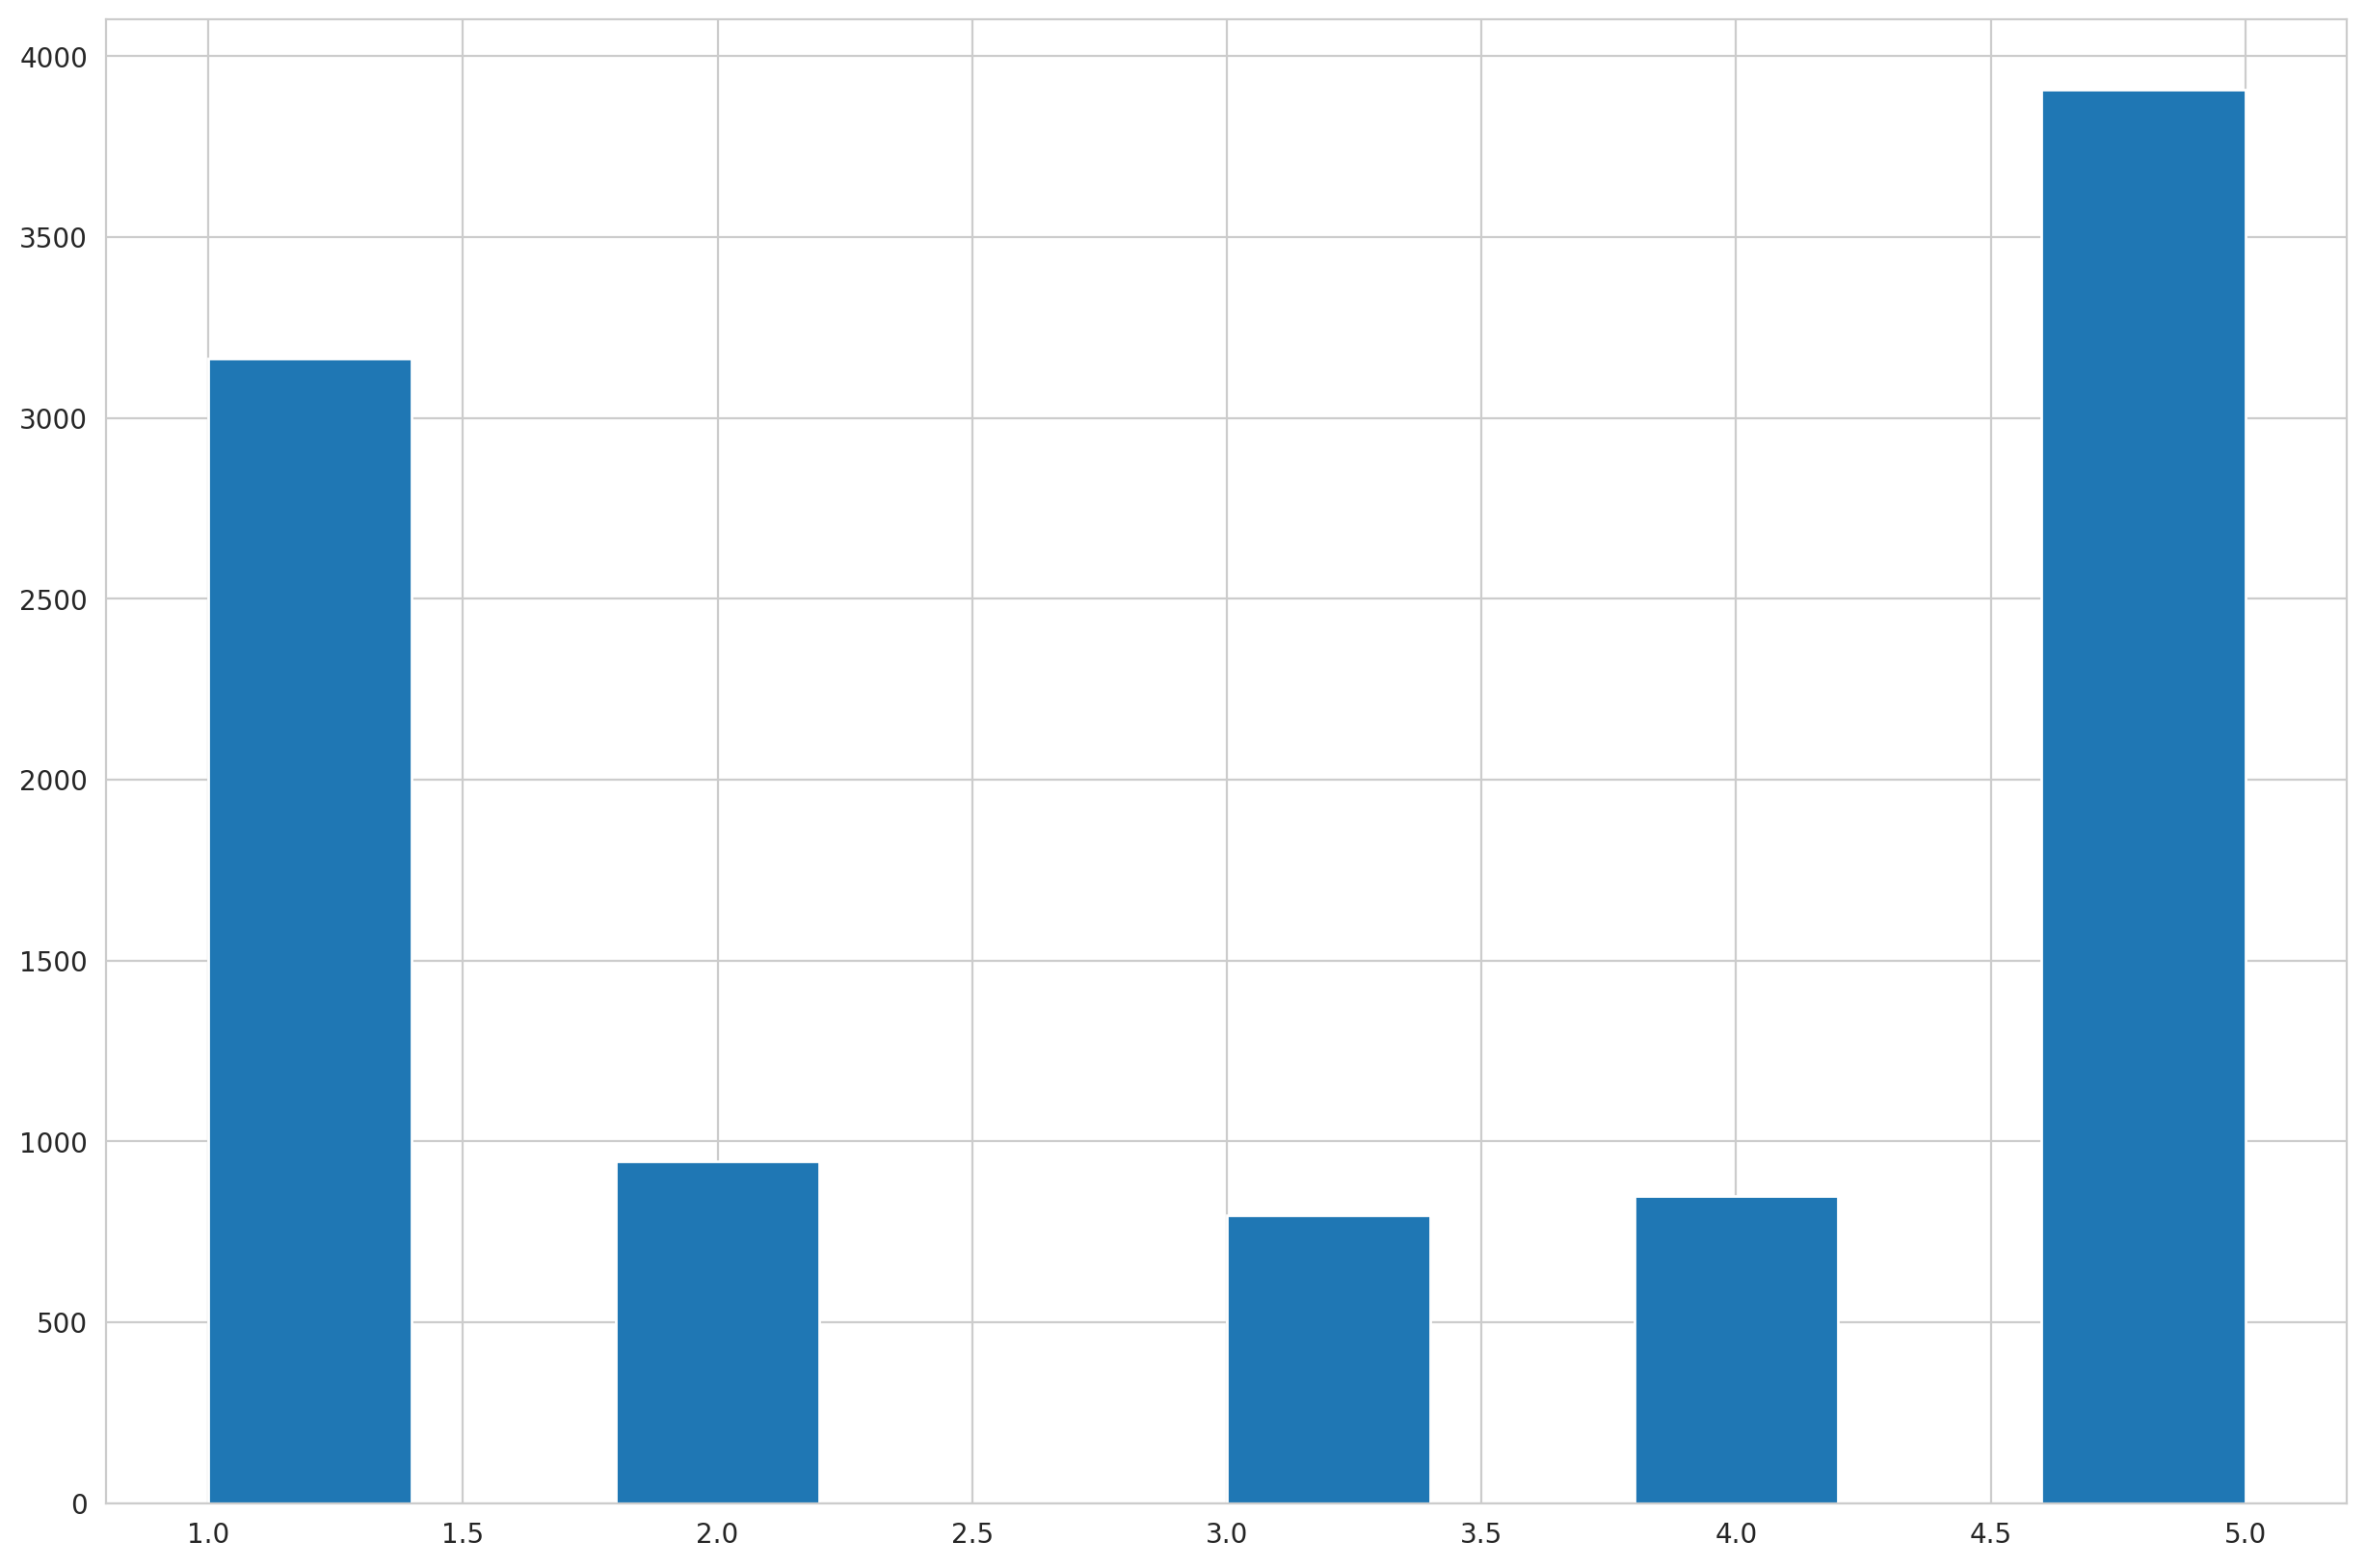

In [36]:
plt.hist(df_mbbrev['score'])
plt.show()

In [39]:
!pip install emoji

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.4 MB/s eta 0:00:00


In [40]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
# Handle None values in 'content' column by replacing them with empty strings
df_mbbrev['sentiment_polarity'] = df_mbbrev['content'].astype(str).apply(lambda x: TextBlob(x).polarity)
df_mbbrev['sentiment_subjective'] = df_mbbrev['content'].astype(str).apply(lambda x: TextBlob(x).subjectivity)

In [41]:
df_raw = df_mbbrev.loc[:,["content","score","raw_polarity", "raw_subjectivity"]]
df_clean = df_mbbrev.loc[:,["content","score","clean_polarity", "clean_subjectivity"]]

In [42]:
df_raw

,content,score,raw_polarity,raw_subjectivity
0,aplikasi sampah gabisa order sama sekali yang bener kalo bikin apps,1,0.000000,0.00
1,fantastic app service is aaa+++,5,0.400000,0.90
2,ini aplikasi bagus hanya saja banyak supir2 baru yang ga tau jalan dan kemampuan nyetirnya sangat kurang. sehingga penumpang yang tinggal duduk manis jadi harus ngarahin jalan dan banyak di klakso...,1,-0.100000,0.60
3,in which country taxi available,1,0.400000,0.40
4,efficient service. clean vehicles. language becomes a problem sometimes.,4,0.366667,0.70
...,...,...,...,...
9656,great app. sangat membantu.,4,0.800000,0.75
9657,"akhirnya setelah di blackberry, dibuat juga aplikasi buat android...semoga semakin jaya blue bird! *two thumbs up*",5,0.000000,0.10
9658,"pagi jam 4 saya pesan taksi berjalan dengan baik, muncul notifikasi apabila sudah mendapat mobil dan posisi mobil bisa dilacak di petanya. bagus.",4,0.000000,0.00
9659,pertama kali make app ini gw seneng banget karena gw bisa track dari gadget gw udah dimana taksinya. sayang untuk tujuannya ga bs ganti dari airport?,2,0.000000,0.00


In [43]:
df_clean

,content,score,clean_polarity,clean_subjectivity
0,aplikasi sampah gabisa order sama sekali yang bener kalo bikin apps,1,0.000000,0.00
1,fantastic app service is aaa+++,5,0.400000,0.90
2,ini aplikasi bagus hanya saja banyak supir2 baru yang ga tau jalan dan kemampuan nyetirnya sangat kurang. sehingga penumpang yang tinggal duduk manis jadi harus ngarahin jalan dan banyak di klakso...,1,-0.100000,0.60
3,in which country taxi available,1,0.400000,0.40
4,efficient service. clean vehicles. language becomes a problem sometimes.,4,0.366667,0.70
...,...,...,...,...
9656,great app. sangat membantu.,4,0.800000,0.75
9657,"akhirnya setelah di blackberry, dibuat juga aplikasi buat android...semoga semakin jaya blue bird! *two thumbs up*",5,0.000000,0.10
9658,"pagi jam 4 saya pesan taksi berjalan dengan baik, muncul notifikasi apabila sudah mendapat mobil dan posisi mobil bisa dilacak di petanya. bagus.",4,0.000000,0.00
9659,pertama kali make app ini gw seneng banget karena gw bisa track dari gadget gw udah dimana taksinya. sayang untuk tujuannya ga bs ganti dari airport?,2,0.000000,0.00


In [44]:
#DATA PREPROCESSING
# Lower casing
# Change the reviews type to string
df_mbbrev['content'] = df_mbbrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_mbbrev['content'][11])
print(df_mbbrev['content'][1])
print(df_mbbrev['content'][20])

when writing a message, it always errors
fantastic app service is aaa+++
saat mengisi email, katanya wrong format. saya hubungi cs nya. diminta via wa saya hub wa, dijawab pakai robot aplikasi ga bermanfaat


In [45]:
#Lowercase all reviews to see the difference
df_mbbrev['content']= df_mbbrev['content'].apply(lambda x: x.lower())
print(df_mbbrev['content'][11])
print(df_mbbrev['content'][1])
print(df_mbbrev['content'][20])

when writing a message, it always errors
fantastic app service is aaa+++
saat mengisi email, katanya wrong format. saya hubungi cs nya. diminta via wa saya hub wa, dijawab pakai robot aplikasi ga bermanfaat


In [46]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get Indonesian stopwords
indonesian_stopwords = stopwords.words('indonesian')

# Display first 20 stopwords
print(indonesian_stopwords[:20])

['ada', 'adalah', 'adanya', 'adapun', 'agak', 'agaknya', 'agar', 'akan', 'akankah', 'akhir', 'akhiri', 'akhirnya', 'aku', 'akulah', 'amat', 'amatlah', 'anda', 'andalah', 'antar', 'antara']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
import string

df_mbbrev['wordCount'] = [len(review.split()) for review in df_mbbrev['content']]
df_mbbrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
    for review in df_mbbrev['content']]
df_mbbrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
    for review in df_mbbrev['content']]

In [48]:
df_mbbrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,aplikasi sampah gabisa order sama sekali yang bener kalo bikin apps,1,0.000000,0.00,11,0,0
1,fantastic app service is aaa+++,5,0.400000,0.90,5,0,3
2,ini aplikasi bagus hanya saja banyak supir2 baru yang ga tau jalan dan kemampuan nyetirnya sangat kurang. sehingga penumpang yang tinggal duduk manis jadi harus ngarahin jalan dan banyak di klakso...,1,-0.100000,0.60,75,0,10
3,in which country taxi available,1,0.400000,0.40,5,0,0
4,efficient service. clean vehicles. language becomes a problem sometimes.,4,0.366667,0.70,9,0,3
...,...,...,...,...,...,...,...
9656,great app. sangat membantu.,4,0.800000,0.75,4,0,2
9657,"akhirnya setelah di blackberry, dibuat juga aplikasi buat android...semoga semakin jaya blue bird! *two thumbs up*",5,0.000000,0.10,16,0,7
9658,"pagi jam 4 saya pesan taksi berjalan dengan baik, muncul notifikasi apabila sudah mendapat mobil dan posisi mobil bisa dilacak di petanya. bagus.",4,0.000000,0.00,23,0,3
9659,pertama kali make app ini gw seneng banget karena gw bisa track dari gadget gw udah dimana taksinya. sayang untuk tujuannya ga bs ganti dari airport?,2,0.000000,0.00,26,0,2


In [49]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_mbbrev['sentiment_rating'] = df_mbbrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [50]:
df_mbbrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,aplikasi sampah gabisa order sama sekali yang bener kalo bikin apps,1,0.000000,0.00,Negative
1,fantastic app service is aaa+++,5,0.400000,0.90,Positive
2,ini aplikasi bagus hanya saja banyak supir2 baru yang ga tau jalan dan kemampuan nyetirnya sangat kurang. sehingga penumpang yang tinggal duduk manis jadi harus ngarahin jalan dan banyak di klakso...,1,-0.100000,0.60,Negative
3,in which country taxi available,1,0.400000,0.40,Negative
4,efficient service. clean vehicles. language becomes a problem sometimes.,4,0.366667,0.70,Positive
...,...,...,...,...,...
9656,great app. sangat membantu.,4,0.800000,0.75,Positive
9657,"akhirnya setelah di blackberry, dibuat juga aplikasi buat android...semoga semakin jaya blue bird! *two thumbs up*",5,0.000000,0.10,Positive
9658,"pagi jam 4 saya pesan taksi berjalan dengan baik, muncul notifikasi apabila sudah mendapat mobil dan posisi mobil bisa dilacak di petanya. bagus.",4,0.000000,0.00,Positive
9659,pertama kali make app ini gw seneng banget karena gw bisa track dari gadget gw udah dimana taksinya. sayang untuk tujuannya ga bs ganti dari airport?,2,0.000000,0.00,Negative


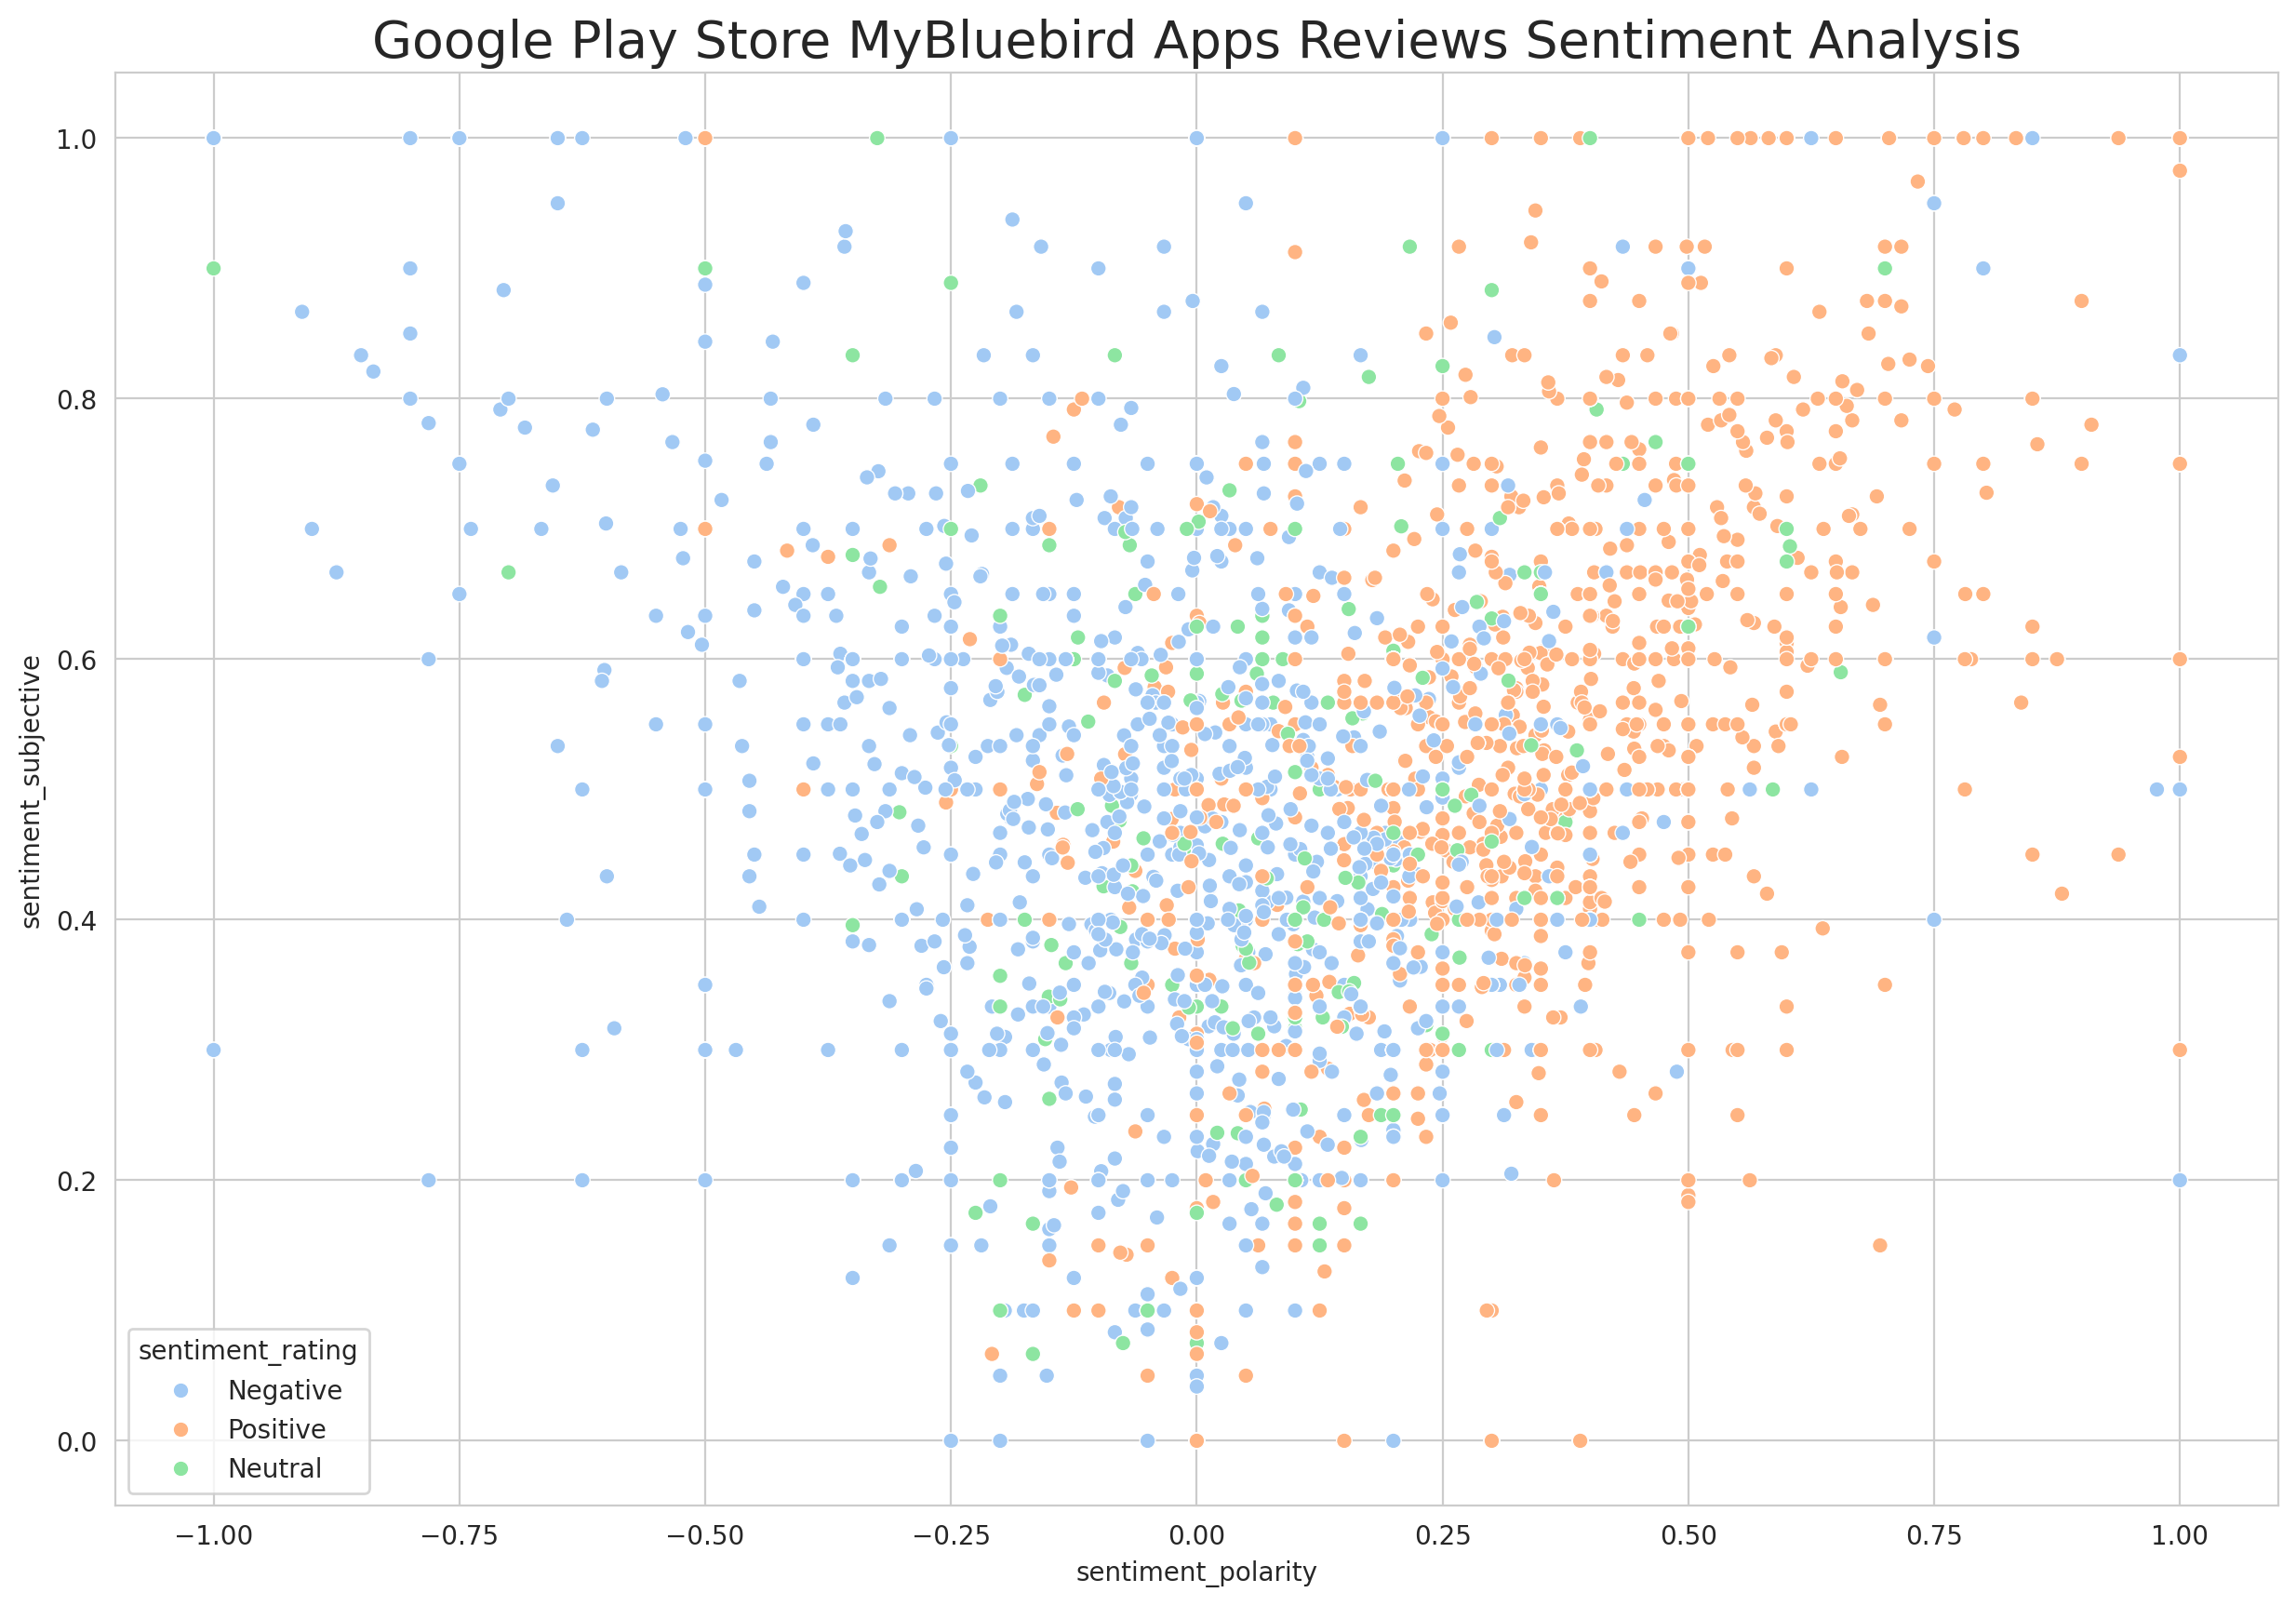

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
# Specify x and y using the 'x' and 'y' parameters within sns.scatterplot
sns.scatterplot(x=df_mbbrev['sentiment_polarity'], y=df_mbbrev['sentiment_subjective'],
                hue=df_mbbrev['sentiment_rating'], edgecolor='white', palette="pastel")
plt.title("Google Play Store MyBluebird Apps Reviews Sentiment Analysis", fontsize=20)
plt.show()

In [53]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

/tmp/ipython-input-2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


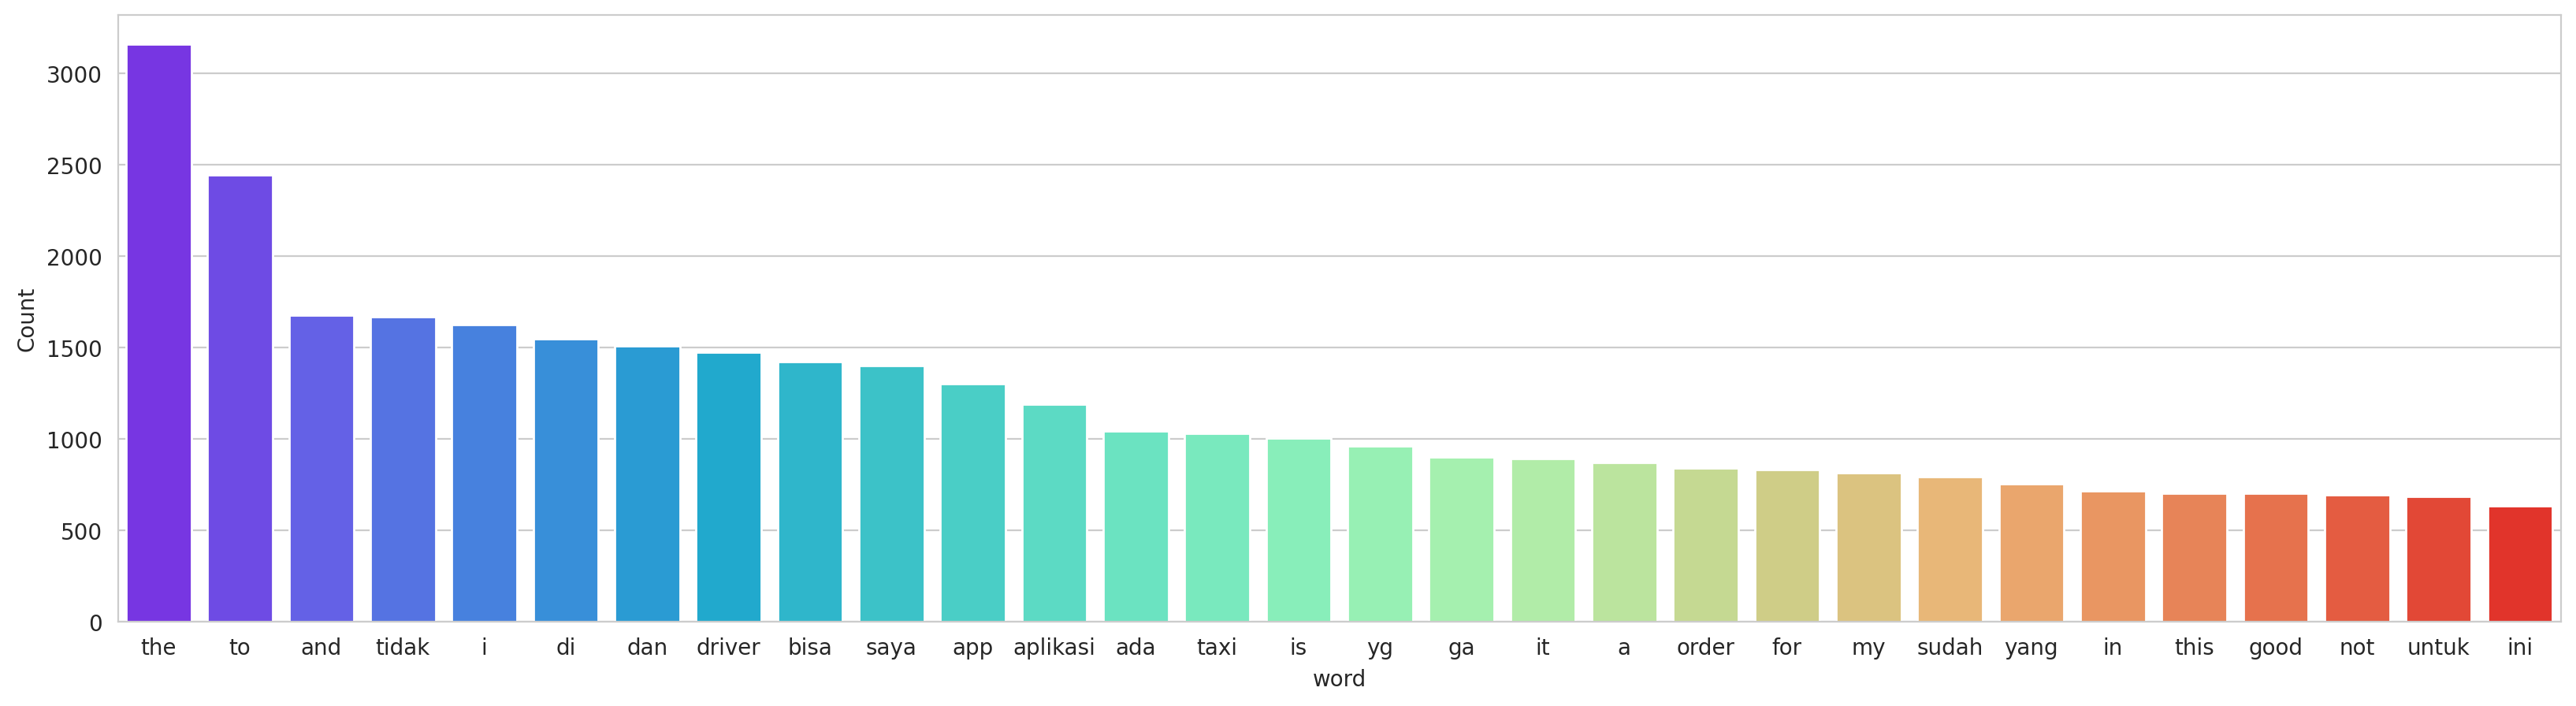

In [54]:
freq_words(df_mbbrev['content'])

In [55]:
# prompt: the [content] column hasnt been applied Indonesian stopwords removal using Sastrawi

# !pip install Sastrawi

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Create stopword remover
factory = StopWordRemoverFactory()
stopword_remover = factory.create_stop_word_remover()

# Apply stopword removal to the 'content' column
df_mbbrev['content'] = df_mbbrev['content'].apply(lambda x: stopword_remover.remove(x))


In [56]:
# prompt: can you also apply English stopwords as well to the [content] column

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Get English stopwords
english_stopwords = stopwords.words('english')

# Assuming df_mbbrev is your DataFrame and 'content' is the column
df_mbbrev['content'] = df_mbbrev['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in english_stopwords]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
len(english_stopwords)

198

In [58]:
df_mbbrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,aplikasi sampah gabisa order sama sekali bener kalo bikin apps,1,0.000000,0.00,Negative
1,fantastic app service aaa+++,5,0.400000,0.90,Positive
2,aplikasi bagus saja banyak supir2 baru ga tau jalan kemampuan nyetirnya sangat kurang. penumpang tinggal duduk manis jadi ngarahin jalan banyak klakson2 orang nyupirnya ngalang2in mobil/ motor lai...,1,-0.100000,0.60,Negative
3,country taxi available,1,0.400000,0.40,Negative
4,efficient service. clean vehicles. language becomes problem sometimes.,4,0.366667,0.70,Positive
...,...,...,...,...,...
9656,great app. sangat membantu.,4,0.800000,0.75,Positive
9657,"akhirnya di blackberry, dibuat aplikasi buat android...semoga semakin jaya blue bird! *two thumbs up*",5,0.000000,0.10,Positive
9658,"pagi jam 4 pesan taksi berjalan baik, muncul notifikasi apabila mendapat mobil posisi mobil dilacak petanya. bagus.",4,0.000000,0.00,Positive
9659,pertama kali make app gw seneng banget gw track gadget gw udah taksinya. sayang tujuannya ga bs ganti airport?,2,0.000000,0.00,Negative


In [59]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

/tmp/ipython-input-2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


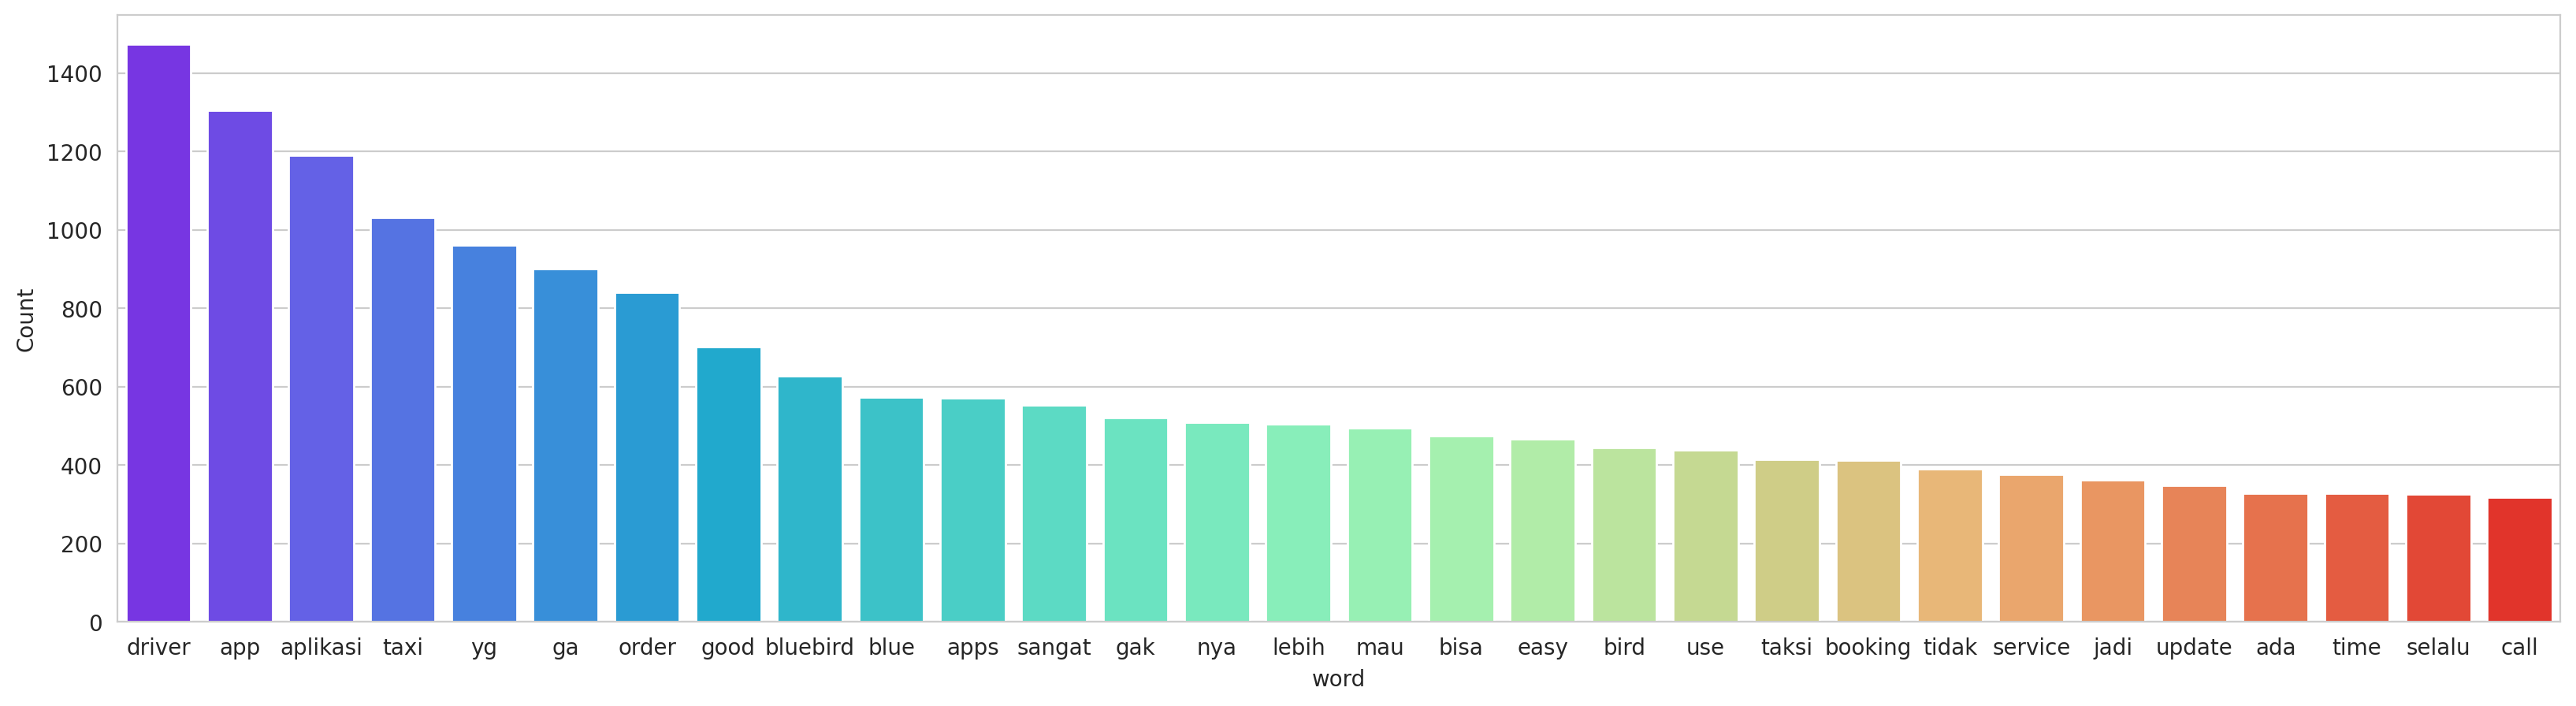

In [60]:
freq_words(df_mbbrev['content'])

In [61]:
custom_stopwords = {"ga", "yg", "aplikasi", "app", "gak", "nya"}
# Assuming df_mbbrev is your DataFrame and 'content' is the column
df_mbbrev['content'] = df_mbbrev['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in custom_stopwords]))


In [62]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  #Import FreqDist from nltk.probability
  from nltk.probability import FreqDist
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  # Use the 'rainbow' colormap for the bar plot
  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")
  ax.set(ylabel = 'Count')
  plt.show()

/tmp/ipython-input-2152088084.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=d, x= "word", y = "count", palette="rainbow")


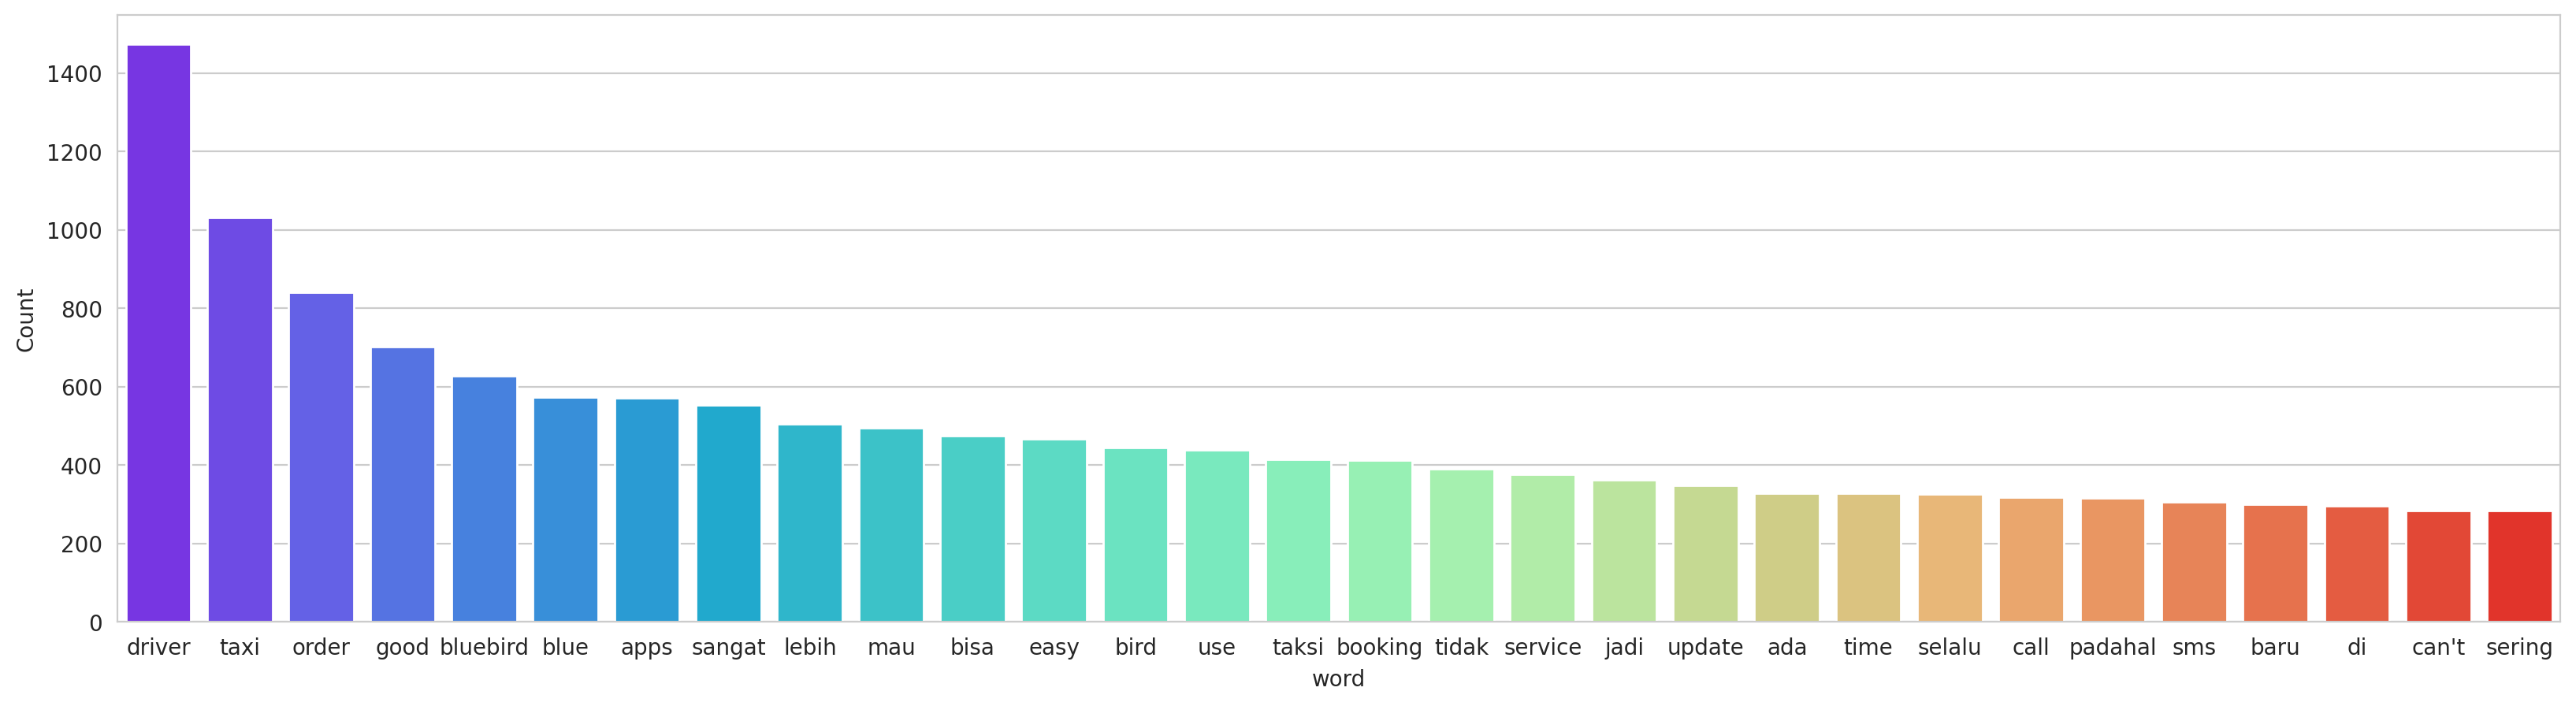

In [63]:
freq_words(df_mbbrev['content'])

# Generate Data CLean

In [65]:
# Save clean dataset
df_mbbrev.to_csv('mybluebird_clean.csv', index=False)
print("Clean dataset saved as mybluebird_clean.csv")

Clean dataset saved as mybluebird_clean.csv
